# <b>Google Play Store Apps Rating Prediction

작성자 : 허은정

마지막 수정 : 20.06.13 14:00

Contents
1. Install Libraries
2. Read .csv
3. Preprocessing & EDA
4. Preprocessing at once
5. Baseline Modeling
6. Optimized Modeling
7. Ensembled Modeling
8. Interpretation

######install libraries

In [ ]:
# 데이터 전처리
import pandas as pd                                  # 데이터 조작, 분석
import numpy as np                                   # 행렬 연산
import math                                          # 연산
import random                                        # 난수 생성
 
# 모델링
from sklearn.model_selection import train_test_split # train, validation 데이터 나누기
from sklearn import metrics                          # 평가 지표 측정
from sklearn.linear_model import LinearRegression    # 다중 선형 회귀 모델링
import lightgbm as lgb                               # lightGBM 모델링
from keras.models import Sequential                  # 신경망 모델링
from keras.layers import Dense
from keras.layers import ELU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold            # K-fold CV    
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization           # 베이지안 최적화 라이브러리  
from functools import partial                        # 함수 변수 고정
 
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=d9b9b2ee96df48711e16c99c8b73218dcc57173b1ce462cbd85fe9416f2185ed
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


###### Read .csv

In [ ]:
data = pd.read_csv('appstore.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


###### Preprocessing & EDA

In [ ]:
# 전체 데이터 점검 -> 열이 밀려있는 경우, 검색으로 대체값 찾아 넣음
data[data.Category == '1.9']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [ ]:
temp = data.iloc[10472, 1:12]
temp.index = data.columns[2:13]
data.iloc[10472, 2:13] = temp
data.iloc[10472, 1], data.iloc[10472, 9] = 'LIFESTYLE', 'Lifestyle'
data[data.App == 'Life Made WI-Fi Touchscreen Photo Frame']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,LIFESTYLE,1.9,19,3.0M,"1,000+",Free,0,Everyone,Lifestyle,"February 11, 2018",1.0.19,4.0 and up


In [ ]:
# 전체 데이터 점검 -> 중복 값 제거
data = data.drop_duplicates(['App'], keep='first')

In [ ]:
# 종속변수 Rating -> 결측치(NaN) 제거, 데이터 타입 float로 변환
data = data.drop(data[data.Rating.isna()].index)
data.Rating = data.Rating.astype(float)

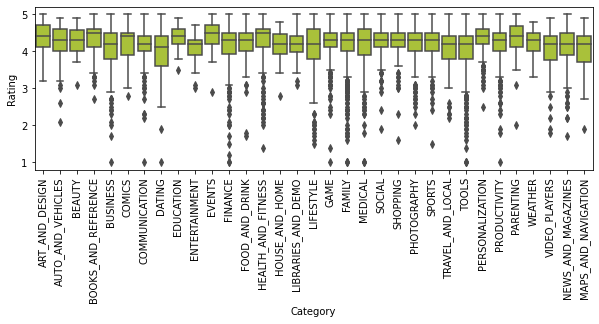

In [ ]:
# Category 변수 -> Rating에 대한 Box-plot
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
sns.boxplot(data.Category, data.Rating, palette=['#b8d823']*23)
plt.show()

In [ ]:
# Category 변수 -> 더미 변수로 변환
data = pd.concat([data, pd.get_dummies(data.Category)], axis=1)

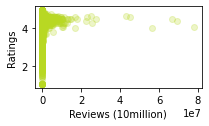

In [ ]:
# Review 변수 -> 데이터타입 int로 변환, Rating과의 Scatter plot
data.Reviews = data.Reviews.astype(int)
plt.figure(figsize=(3,1.5))
plt.xlabel('Reviews (10million)')
plt.ylabel('Ratings')
plt.scatter(data.Reviews, data.Rating, alpha=0.25, color='#b8d823')
plt.show()

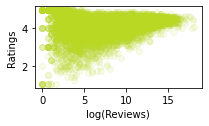

In [ ]:
# Review 변수 -> 로그 변환
plt.figure(figsize=(3,1.5))
plt.xlabel('log(Reviews)')
plt.ylabel('Ratings')
plt.scatter(data.Reviews.map(lambda x: math.log(x)), data.Rating, alpha=0.1, color='#b8d823')
plt.show()
data.Reviews = data.Reviews.map(lambda x: math.log(x))

In [ ]:
# Size 변수 -> 단위 변환, 데이터 타입 int로 변환
data.Size = data.Size.map(lambda x: x.replace('M','000').replace('.','').replace('k',''))
data.Size[data.Size == 'Varies with device'] = data.Size[data.Size != 'Varies with device'].median()
data.Size = data.Size.astype(int)

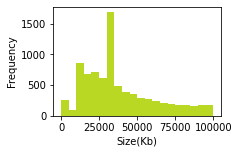

In [ ]:
# Size 변수 -> 결측치 median으로 대체
plt.figure(figsize=(3,2))
plt.xlabel('Size(Kb)')
plt.ylabel('Frequency')
plt.hist(data.Size, bins=20, color='#b8d823')
plt.show()

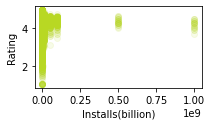

In [ ]:
# Install 변수 -> 데이터 타입 int로 변환, Rating과의 Scatter plot
data.Installs = data.Installs.map(lambda x: x.replace(',','').replace('+','')).astype(int)
plt.figure(figsize=(3,1.5))
plt.xlabel('Installs(billion)')
plt.ylabel('Rating')
plt.scatter(data.Installs, data.Rating, alpha=0.1, color='#b8d823')
plt.show()

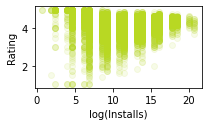

In [ ]:
# Install 변수 -> 로그 변환
plt.figure(figsize=(3,1.5))
plt.xlabel('log(Installs)')
plt.ylabel('Rating')
plt.scatter(data.Installs.map(lambda x: math.log(x+1)), data.Rating, alpha=0.1, color='#b8d823')
plt.show()
data.Installs = data.Installs.map(lambda x: math.log(x))

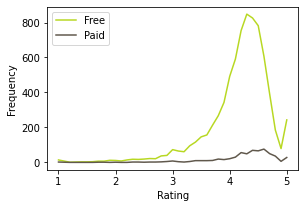

In [ ]:
# Type 변수 -> 결측치 1건 있었으나 Rating 변수 NaN 값 없애면서 없어짐, 데이터타입 int로 변환
#           -> 속성값 별 Rating 분포 그래프
temp = data.iloc[:,[0,2,6]].groupby(['Type','Rating']).count().unstack()
temp = temp.fillna(0).astype(int)
temp.columns = temp.columns.map(lambda x: x[1])
plt.figure(figsize=(4.5,3))
plt.plot(temp.columns, temp.iloc[0], color='#b8d823')
plt.plot(temp.columns, temp.iloc[1], color='#60584c')
plt.legend(temp.index)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Type 변수 -> 더미 변수로 변환
data = pd.concat([data, pd.get_dummies(data.Type)], axis=1)

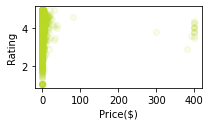

In [ ]:
# Price 변수 -> 데이터 타입 float로 변환, Rating과의 Scatter plot
data.Price = data.Price.map(lambda x: x.replace('$','')).astype(float)
plt.figure(figsize=(3,1.5))
plt.xlabel('Price($)')
plt.ylabel('Rating')
plt.scatter(data.Price, data.Rating, alpha=0.1, color='#b8d823')
plt.show()

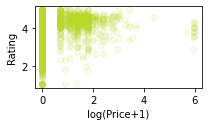

In [ ]:
# Price 변수 -> 로그 변환
plt.figure(figsize=(3,1.5))
plt.xlabel('log(Price+1)')
plt.ylabel('Rating')
plt.scatter(data.Price.map(lambda x: math.log(x+1)), data.Rating, alpha=0.1, color='#b8d823')
plt.show()

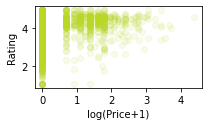

In [ ]:
# Price 변수 -> 이상치 제거
data = data.drop(data[data.Price > 250].index)
plt.figure(figsize=(3,1.5))
plt.xlabel('log(Price+1)')
plt.ylabel('Rating')
plt.scatter(data.Price.map(lambda x: math.log(x+1)), data.Rating, alpha=0.1, color='#b8d823')
data.Price = data.Price.map(lambda x: math.log(x+1))

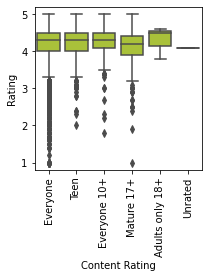

In [ ]:
# Content Rating 변수 -> Box plot으로 분포 확인
plt.figure(figsize=(3,3))
plt.xticks(rotation=90)
sns.boxplot(data['Content Rating'], data.Rating, palette=['#b8d823']*6)
plt.show()

In [ ]:
# Content Rating 변수 -> 이상치 제거, 더미 변수로 변환
data = data.drop(data[data['Content Rating'] == 'Unrated'].index)
data = pd.concat([data, pd.get_dummies(data['Content Rating'])], axis=1)

In [ ]:
# Genres 변수 -> 제1정규화, 더미 변수로 변환
temp = data.Genres.str.split(';')
t = pd.DataFrame(temp.map(lambda x: x[0]))
t = t.append(pd.DataFrame(temp[temp.map(lambda x: len(x) > 1)].map(lambda x: x[1])))
t['App'], t['count'] = data['App'], 1
t = t.groupby(['Genres','App']).count().unstack(level=0)
t.columns = t.columns.map(lambda x: x[1])
data.set_index(['App'], inplace=True)
for i in t.columns:
  data[i] = t[i]
  data[i] = data[i].fillna(0).astype(int)

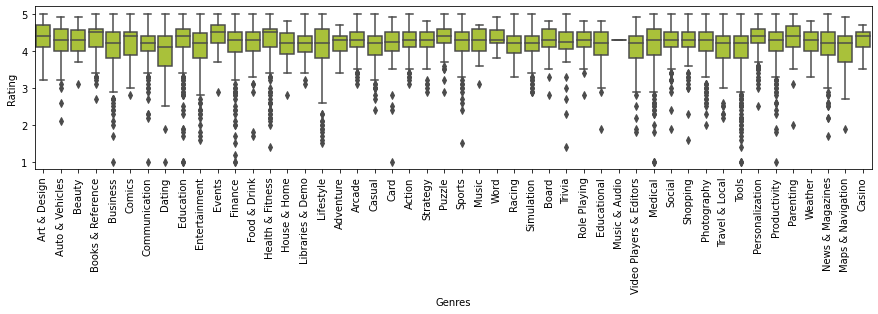

In [ ]:
# Genres 변수 -> Box plot으로 분포 파악
plt.figure(figsize=(15,3))
plt.xticks(rotation=90)
tt = temp.map(lambda x: x[0])
tt.index = data.index
sns.boxplot(tt, data.Rating, palette=['#b8d823']*48)
plt.show()

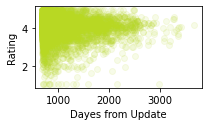

In [ ]:
# Last Updated 변수 -> Days from Update로 변환, Rating과의 Scatter plot
data['Days from Update'] = (pd.to_datetime('2020-06-18') - pd.to_datetime(data['Last Updated'])).map(lambda x: str(x)[:str(x).find(' ')]).astype(int)
plt.figure(figsize=(3,1.5))
plt.xlabel('Dayes from Update')
plt.ylabel('Rating')
plt.scatter(data['Days from Update'], data.Rating, alpha=0.1, color='#b8d823')
plt.show()

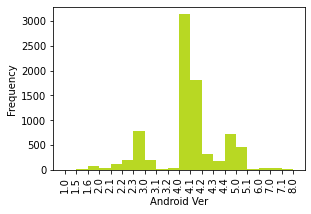

In [ ]:
# Android Ver 변수 -> 주번호, 부번호까지만 사용, 더미 변수로 변환
temp = data['Android Ver'].map(lambda x: str(x)[:(str(x).find('.')+2)])
temp[(temp == 'V') | (temp == 'n')] = '4.0'
data = pd.concat([data, pd.get_dummies(temp)], axis=1)
data['Updating'] = 1
data.Updating[data['Android Ver'].map(lambda x: str(x).find('-') > 0)] = 0
plt.figure(figsize=(4.5,3))
plt.xlabel('Android Ver')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.hist(sorted(temp), bins=20, color='#b8d823')
plt.show()

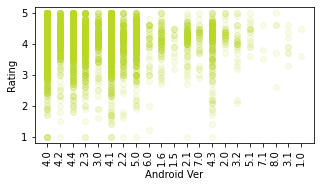

In [ ]:
# Android Ver 변수 -> Rating과의 Scatter plot
plt.figure(figsize=(5,2.5))
plt.xlabel('Android Ver')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.scatter(temp, data.Rating, alpha=0.1, color='#b8d823')
plt.show()

###### Preprocessing at once

In [ ]:
# 데이터 불러오기
data = pd.read_csv('appstore.csv')

# 밀린 열
temp = data.iloc[10472, 1:12]
temp.index = data.columns[2:13]
data.iloc[10472, 2:13] = temp
data.iloc[10472, 1], data.iloc[10472, 9] = 'LIFESTYLE', 'Lifestyle'

# 중복 제거
data = data.drop_duplicates(['App'], keep='first')

# Rating
data = data.drop(data[data.Rating.isna()].index)
data.Rating = data.Rating.astype(float)

# Category
data = pd.concat([data, pd.get_dummies(data.Category)], axis=1)

# Reviews
data.Reviews = data.Reviews.astype(int)
data.Reviews = data.Reviews.map(lambda x: math.log(x))

# Size
data.Size = data.Size.map(lambda x: x.replace('M','000').replace('.','').replace('k',''))
data.Size[data.Size == 'Varies with device'] = data.Size[data.Size != 'Varies with device'].median()
data.Size = data.Size.astype(int)

# Installs
data.Installs = data.Installs.map(lambda x: x.replace(',','').replace('+','')).astype(int)
data.Installs = data.Installs.map(lambda x: math.log(x))

# Type
data = pd.concat([data, pd.get_dummies(data.Type)], axis=1)

# Price
data.Price = data.Price.map(lambda x: x.replace('$','')).astype(float)
data = data.drop(data[data.Price > 250].index)
data.Price = data.Price.map(lambda x: math.log(x+1))

# Content Rating
data = data.drop(data[data['Content Rating'] == 'Unrated'].index)
data = pd.concat([data, pd.get_dummies(data['Content Rating'])], axis=1)

# Genres
temp = data.Genres.str.split(';')
t = pd.DataFrame(temp.map(lambda x: x[0]))
t = t.append(pd.DataFrame(temp[temp.map(lambda x: len(x) > 1)].map(lambda x: x[1])))
t['App'], t['count'] = data['App'], 1
t = t.groupby(['Genres','App']).count().unstack(level=0)
t.columns = t.columns.map(lambda x: x[1])
data.set_index(['App'], inplace=True)
for i in t.columns:
  data[i] = t[i]
  data[i] = data[i].fillna(0).astype(int)

# Last Updated
data['Days from Update'] = (pd.to_datetime('2020-06-18') - pd.to_datetime(data['Last Updated'])).map(lambda x: str(x)[:str(x).find(' ')]).astype(int)

# Android Ver
temp = data['Android Ver'].map(lambda x: str(x)[:(str(x).find('.')+2)])
temp[(temp == 'V') | (temp == 'n')] = '4.0'
data = pd.concat([data, pd.get_dummies(temp)], axis=1)
data['Updating'] = 1
data.Updating[data['Android Ver'].map(lambda x: str(x).find('-') > 0)] = 0

###### Baseline Modeling

In [ ]:
# X, y 분리
X = data.drop(['Category','Rating','Type','Content Rating','Genres','Last Updated','Current Ver','Android Ver'], axis=1)
y = data.Rating

# 3-fold Cross Validation
kf = KFold(n_splits=3, random_state=2020)

In [ ]:
# Linear Regression

lr_model = LinearRegression()

lr_mae = 0
lr_rmse = 0

for train_index, valid_index in kf.split(X):
  train_X, train_y = X.iloc[train_index], y[train_index]
  valid_X, valid_y = X.iloc[valid_index], y[valid_index]
  
  lr_model.fit(train_X, train_y)   # 학습
  pred = lr_model.predict(valid_X) # 예측
  pred[pred < 1] = 1.0             # 예측 이탈 범위 조정
  pred[pred > 5] = 5.0

  lr_mae += metrics.mean_absolute_error(valid_y, pred)/3
  lr_rmse += metrics.mean_squared_error(valid_y, pred, squared=False)/3

In [ ]:
# Decision Tree

dt_model = lgb.LGBMRegressor(n_estimators=25000, # boosting iteration
                             random_seed=2020)

dt_mae = 0
dt_rmse = 0

for train_index, valid_index in kf.split(X):
  train_X, train_y = X.iloc[train_index], y[train_index]
  valid_X, valid_y = X.iloc[valid_index], y[valid_index]
  
  dt_model.fit(train_X, train_y,             # 학습
               eval_set=(valid_X, valid_y),  # validation set
               eval_metric='l2',             # loss function
               early_stopping_rounds=5000,   # loss function 개선 없으면 학습 중단
               verbose=0)                    # 중간결과 출력 X
  pred = dt_model.predict(valid_X)           # 예측
  pred[pred < 1] = 1.0                       # 예측 이탈 범위 조정
  pred[pred > 5] = 5.0

  dt_mae += metrics.mean_absolute_error(valid_y, pred)/3
  dt_rmse += metrics.mean_squared_error(valid_y, pred, squared=False)/3

In [ ]:
# Neural Network

atv = ELU(alpha=1.0)
nn_model = Sequential()
nn_model.add(Dense(units=120, activation=atv, input_dim=120))
nn_model.add(Dense(units=64, activation=atv))
nn_model.add(Dense(units=64, activation=atv))
nn_model.add(Dense(units=16, activation=atv))
nn_model.add(Dense(units=8, activation=atv))
nn_model.add(Dense(units=1, activation='linear'))
nn_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

nn_mae = 0
nn_rmse = 0

for train_index, valid_index in kf.split(X):
  train_X, train_y = X.iloc[train_index], y[train_index]
  valid_X, valid_y = X.iloc[valid_index], y[valid_index]
    
  nn_model.fit(train_X, train_y,   # 학습
               epochs=2000,
               batch_size=25000, 
               validation_data=(valid_X, valid_y), 
               verbose=0)
    
  pred = nn_model.predict(valid_X) # 예측
  pred[pred < 1] = 1            # 예측 이탈 범위 조정
  pred[pred > 5] = 5

  nn_mae += metrics.mean_absolute_error(valid_y, pred)/3
  nn_rmse += metrics.mean_squared_error(valid_y, pred, squared=False)/3

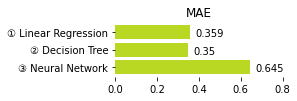

In [ ]:
# MAE
plt.figure(figsize=(3,1))
plt.title('MAE')
plt.barh(['③ Neural Network','② Decision Tree','① Linear Regression'],[nn_mae, dt_mae, lr_mae], color='#b8d823')
plt.xlim(0, 0.8)
plt.box(False)
plt.text(nn_mae+0.025, -0.25, round(nn_mae,3))
plt.text(dt_mae+0.025, 0.75, round(dt_mae,3))
plt.text(lr_mae+0.025, 1.75, round(lr_mae,3))
plt.show()

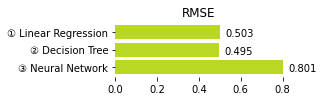

In [ ]:
# RMSE
plt.figure(figsize=(3,1))
plt.title('RMSE')
plt.barh(['③ Neural Network','② Decision Tree','① Linear Regression'],[nn_rmse, dt_rmse, lr_rmse], color='#b8d823')
plt.xlim(0,0.8)
plt.box(False)
plt.text(nn_rmse+0.025, -0.25, round(nn_rmse,3))
plt.text(dt_rmse+0.025, 0.75, round(dt_rmse,3))
plt.text(lr_rmse+0.025, 1.75, round(lr_rmse,3))
plt.show()

###### Optimized Modeling

In [ ]:
# Decision Tree

dt_model = lgb.LGBMRegressor(n_estimators=25000,
                             num_leaves=256,
                             max_depth=10,
                             learning_rate=0.005,
                             reg_lambda=256,
                             random_seed=2020)

dt_mae_opt = 0
dt_rmse_opt = 0

for train_index, valid_index in kf.split(X):
  train_X, train_y = X.iloc[train_index], y[train_index]
  valid_X, valid_y = X.iloc[valid_index], y[valid_index]

  dt_model.fit(train_X, train_y,   # 학습
               eval_set=(valid_X, valid_y),
               eval_metric='l2',
               early_stopping_rounds=2500, 
               verbose=0)
  pred = dt_model.predict(valid_X) # 예측
  pred[pred < 1] = 1.0          # 예측 이탈 범위 조정
  pred[pred > 5] = 5.0

  dt_mae_opt += metrics.mean_absolute_error(valid_y, pred)/3
  dt_rmse_opt += metrics.mean_squared_error(valid_y, pred, squared=False)/3

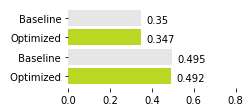

In [ ]:
plt.figure(figsize=(3,1.5))
plt.barh([' Optimized',' Baseline','Optimized','Baseline'],
         [dt_rmse_opt, dt_rmse, dt_mae_opt, dt_mae],
         color=['#b8d823','#e6e6e6','#b8d823','#e6e6e6'])
plt.xlim(0, 0.8)
plt.box(False)
plt.text(dt_rmse_opt+0.025, -0.25, round(dt_rmse_opt,3))
plt.text(dt_rmse+0.025, 0.75, round(dt_rmse,3))
plt.text(dt_mae_opt+0.025, 1.75, round(dt_mae_opt,3))
plt.text(dt_mae+0.025, 2.75, round(dt_mae,3))
plt.show()

In [ ]:
# Neural Network

atv = ELU(alpha=1.0)
nn_model = Sequential()
nn_model.add(Dense(units=120, activation=atv, input_dim=120))
nn_model.add(Dense(units=128, activation=atv))
nn_model.add(Dense(units=128, activation=atv))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(units=128, activation=atv))
nn_model.add(Dense(units=128, activation=atv))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(units=128, activation=atv))
nn_model.add(Dense(units=128, activation=atv))
nn_model.add(Dense(units=1, activation='linear'))
nn_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

nn_mae_opt = 0
nn_rmse_opt = 0

for train_index, valid_index in kf.split(X):
  train_X, train_y = X.iloc[train_index], y[train_index]
  valid_X, valid_y = X.iloc[valid_index], y[valid_index]
    
  nn_model.fit(train_X, train_y, 
               epochs=2000,
               batch_size=25000,
               validation_data=(valid_X, valid_y), 
               verbose=0)
    
  pred = nn_model.predict(valid_X)
  pred[pred < 1] = 1
  pred[pred > 5] = 5

  nn_mae_opt += metrics.mean_absolute_error(valid_y, pred)/3
  nn_rmse_opt += metrics.mean_squared_error(valid_y, pred, squared=False)/3

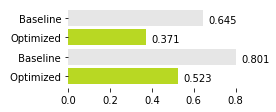

In [ ]:
plt.figure(figsize=(3,1.5))
plt.barh([' Optimized',' Baseline','Optimized','Baseline'],
         [nn_rmse_opt, nn_rmse, nn_mae_opt, nn_mae],
         color=['#b8d823','#e6e6e6','#b8d823','#e6e6e6'])
plt.xlim(0, 0.8)
plt.box(False)
plt.text(nn_rmse_opt+0.025, -0.25, round(nn_rmse_opt,3))
plt.text(nn_rmse+0.025, 0.75, round(nn_rmse,3))
plt.text(nn_mae_opt+0.025, 1.75, round(nn_mae_opt,3))
plt.text(nn_mae+0.025, 2.75, round(nn_mae,3))
plt.show()

###### Ensembled Modeling

In [ ]:
# Stacking

stacked_mae = 0
stacked_rmse = 0

for train_index, valid_index in kf.split(train):
  train_X, train_y = train.iloc[train_index], test[train_index]
  valid_X, valid_y = train.iloc[valid_index], test[valid_index]
  
  stacked_pred = np.zeros(len(valid_y))

  # Linear Regression
  
  lr_model.fit(train_X, train_y)
  pred = lr_model.predict(valid_X)
  pred[pred < 1] = 1.0
  pred[pred > 5] = 5.0
  stacked_pred += pred/3

  # Decision Tree

  dt_model.fit(train_X, train_y, 
               eval_set=(valid_X, valid_y),
               eval_metric='l2',
               early_stopping_rounds=2500, 
               verbose=0)
  pred = dt_model.predict(valid_X)
  pred[pred < 1] = 1.0
  pred[pred > 5] = 5.0
  stacked_pred += pred/3

  # Neural Network

  nn_model.fit(train_X, train_y, 
               epochs=2000, 
               batch_size=25000, 
               validation_data=(valid_X, valid_y),
               verbose=0)
  pred = nn_model.predict(valid_X)
  pred[pred < 1] = 1.0
  pred[pred > 5] = 5.0
  stacked_pred += np.array([x[0] for x in pred])/3

  stacked_mae += metrics.mean_absolute_error(valid_y, stacked_pred)/3
  stacked_rmse += metrics.mean_squared_error(valid_y, stacked_pred, squared=False)/3

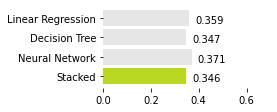

In [ ]:
# MAE
plt.figure(figsize=(3,1.5))
plt.barh(['Stacked','Neural Network','Decision Tree','Linear Regression'],
         [stacked_mae, nn_mae_opt, dt_mae_opt, lr_mae], 
         color=['#b8d823','#e6e6e6','#e6e6e6','#e6e6e6'])
plt.xlim(0, 0.7)
plt.box(False)
plt.text(stacked_mae+0.025, -0.25, round(stacked_mae, 3))
plt.text(nn_mae_opt+0.025, 0.75, round(nn_mae_opt, 3))
plt.text(dt_mae_opt+0.025, 1.75, round(dt_mae_opt, 3))
plt.text(lr_mae+0.025, 2.75, round(lr_mae, 3))
plt.show()

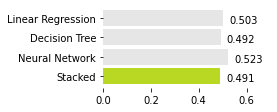

In [ ]:
# RMSE
plt.figure(figsize=(3,1.5))
plt.barh(['Stacked','Neural Network','Decision Tree','Linear Regression'],
         [stacked_rmse, nn_rmse_opt, dt_rmse_opt, lr_rmse], 
         color=['#b8d823','#e6e6e6','#e6e6e6','#e6e6e6'])
plt.xlim(0, 0.7)
plt.box(False)
plt.text(stacked_rmse+0.025, -0.25, round(stacked_rmse, 3))
plt.text(nn_rmse_opt+0.025, 0.75, round(nn_rmse_opt, 3))
plt.text(dt_rmse_opt+0.025, 1.75, round(dt_rmse_opt, 3))
plt.text(lr_rmse+0.025, 2.75, round(lr_rmse, 3))
plt.show()

###### Interpretation

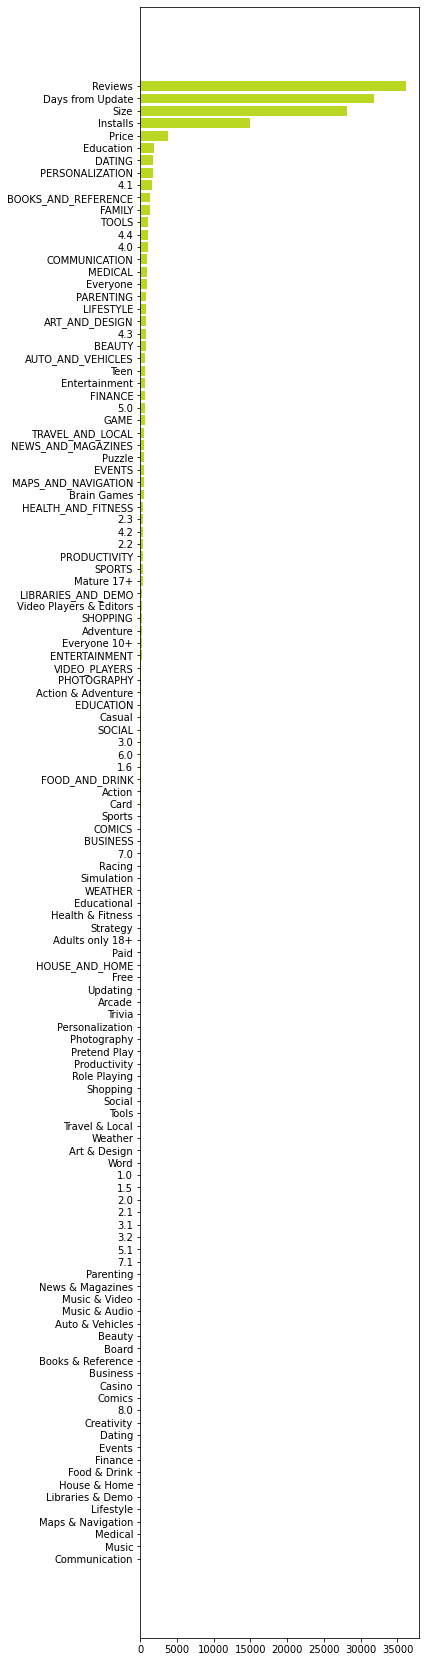

In [ ]:
# Decision Tree에서의 Feature Importances

importance = pd.DataFrame(data={'feature': X.columns, 'importance': dt_model.feature_importances_})
importance = importance.sort_values('importance', ignore_index=True)

plt.figure(figsize=(5,30))
plt.barh(importance.feature, importance.importance, color='#b8d823')
plt.show()

In [ ]:
# Linear Regression에서의 회귀 계수

coef = pd.DataFrame(data={'feature': X.columns, 'coef': lr_model.coef_})
coef[coef.feature.isin(importance.feature[-5:])]

,feature,coef
0,Reviews,1.579736e-01
1,Size,-1.329635e-07
2,Installs,-1.407040e-01
3,Price,-1.763870e-02
97,Days from Update,-1.698437e-04
